In [1]:
GRAPH_FILE_NAME = "no_values.dot"

In [2]:
# Input simulator
class InputSimulator:
    """Crude analog input simulator - ramps back and forth between [lo,hi]"""
    def __init__(self, lo, hi, increment=0.1):
        self._increment = increment
        self._lo = lo
        self._hi = hi
        self._current = lo
        
    def read(self):
        self._current += self._increment
        if self._current < self._lo:
            self._current = self._lo
            self._increment = -self._increment
        if self._current > self._hi:
            self._current = self._hi
            self._increment = -self._increment
        return self._current

field_inputs = {"a": InputSimulator(3,9), "b": InputSimulator(2,6,increment=0.02)}

In [3]:
import pygraphviz
from tango import DeviceProxy
from random import randint

def load_graph(filename: str):
    graph = pygraphviz.AGraph()
    graph.read(filename)
    return graph
    
def render_graph(graph, filename: str):
    graph.layout(prog="dot")
    graph.draw(filename)

In [4]:
# input graph source code
from IPython.display import display, Code
display(Code(load_graph(GRAPH_FILE_NAME).string(), language="dot"))

digraph {
	graph [rankdir=LR];
	node [shape=record];
	"innovation/basic/1"	[label="{{<a>a|<b>b}|innovation/basic/1|{<x>x|<y>y}}"];
	"innovation/basic/2"	[label="{{<a>a|<b>b}|innovation/basic/2|{<x>x|<y>y}}"];
	"innovation/basic/1":x -> "innovation/basic/2":a;
	"innovation/basic/1":y -> "innovation/basic/2":b;
	"innovation/basic/2":y -> output;
	"input a" -> "innovation/basic/1":a;
	"input b" -> "innovation/basic/1":b;
}

In [5]:
def _edge_key(edge):
    # edge is under specified (only nodes, no ports!), 
    # we need to make a unique key for our inputs dict
    src_node, dst_node = edge
    src_port = edge.attr["tailport"]
    dst_port = edge.attr["headport"]  # head is where the arrow points to
    return (f"{src_node}:{src_port}", f"{dst_node}:{dst_port}")

def _proxy(device_name: str) -> DeviceProxy:
    db_port_number = 10000
    #db_service = "tango-databaseds"
    #db_namespace = "ska-tango-fbd"
    #db_host = f"{db_service}.{db_namespace}:{db_port_number}"
    db_ip_addr = "192.168.49.97"
    db_host = f"{db_ip_addr}:{db_port_number}"
    return DeviceProxy(f"{db_host}/{device_name}")
        
def signal_transport_and_annotate(graph):

    # read inputs from head end of edges
    inputs = {}    
    for edge in graph.edges():
        src_node, _ = edge
        key = _edge_key(edge)
        if src_node.count("/") == 2:
            # Tango source
            src_attr = edge.attr["tailport"] # tail is origin of arrow
            inputs[key] = getattr(_proxy(src_node), src_attr)
        elif src_node.startswith("input"):
            which_input = src_node.split(" ")[-1]
            inputs[key] = int(field_inputs[which_input].read())

        # Add labels        
        edge.attr["label"] = inputs[key] 
        
    # write outputs to tail of edges
    for edge in graph.edges():
        _, dst_node = edge
        if dst_node.count("/") == 2:
            # Tango destination
            dst_attr = edge.attr["headport"] # head is where the arrow points to
            setattr(_proxy(dst_node), dst_attr, inputs[_edge_key(edge)])

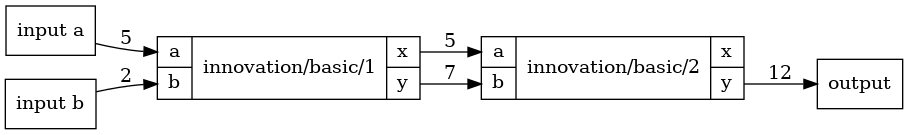

In [6]:
from IPython.display import display, Image
from time import sleep


n=0
while n<30:
    n+=1
    graph = load_graph(GRAPH_FILE_NAME)
    signal_transport_and_annotate(graph)
    render_graph(graph, "render.png")
    display(Image("render.png"), clear=True)
    sleep(0.5)

In [7]:
# graph with value annotations & other rendering cruft
from IPython.display import display, Code
display(Code(graph.string(), language="dot"))

digraph {
	graph [bb="0,0,673,92",
		rankdir=LR
	];
	node [label="\N",
		shape=record
	];
	"innovation/basic/1"	[height=0.65278,
		label="{{<a>a|<b>b}|innovation/basic/1|{<x>x|<y>y}}",
		pos="212.5,45.5",
		rects="114,45.5,140,68.5 114,22.5,140,45.5 140,22.5,286,68.5 286,45.5,311,68.5 286,22.5,311,45.5",
		width=2.7361];
	"innovation/basic/2"	[height=0.65278,
		label="{{<a>a|<b>b}|innovation/basic/2|{<x>x|<y>y}}",
		pos="455.5,45.5",
		rects="357,45.5,383,68.5 357,22.5,383,45.5 383,22.5,529,68.5 529,45.5,554,68.5 529,22.5,554,45.5",
		width=2.7361];
	"innovation/basic/1":x -> "innovation/basic/2":a	[label=5,
		lp="334,65",
		pos="e,357,57.5 311,57.5 327.61,57.5 334.1,57.5 346.92,57.5"];
	"innovation/basic/1":y -> "innovation/basic/2":b	[label=7,
		lp="334,41",
		pos="e,357,33.5 311,33.5 327.61,33.5 334.1,33.5 346.92,33.5"];
	output	[height=0.51389,
		pos="641,33.5",
		rects="609,15.5,673,51.5",
		width=0.88889];
	"innovation/basic/2":y -> output	[label=12,
		lp="581.5,41",
		pos="e,608.95,33.5 554,33.5 568.52,33.5 584.41,33.5 598.54,33.5"];
	"input a"	[height=0.51389,
		pos="34,73.5",
		rects="0.5,55.5,67.5,91.5",
		width=0.93056];
	"input a" -> "innovation/basic/1":a	[label=5,
		lp="91,67",
		pos="e,114,57.5 67.757,63.824 78.772,61.191 91.405,58.812 103.75,57.898"];
	"input b"	[height=0.51389,
		pos="34,18.5",
		rects="0,0.5,68,36.5",
		width=0.94444];
	"input b" -> "innovation/basic/1":b	[label=2,
		lp="91,39",
		pos="e,114,33.5 68.178,27.658 79.135,30.097 91.652,32.291 103.86,33.134"];
}